# Programatically access any loss + penalty combination

`ya_glm` lets you combine a wide array of GLMs (e.g. linear regression, logistic regression, multiple response linear regression, etc) with a wide array of penalties (e.g. Lasso, ElasticNet, Group Lasso, L1 to L2 norm, nuclear norm, etc). We can programaticlaly generate estimators with any combination of GLM loss and penalty.

`ya_glm` also lets you swap in your favorite GLM solver.

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ya_glm.toy_data import sample_sparse_lin_reg, sample_sparse_log_reg
from ya_glm.estimator_getter import get_pen_glm

Text(0.5, 1.0, 'True coefficient')

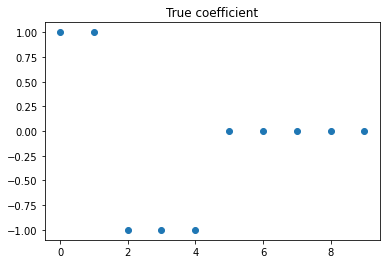

In [2]:
# sample some linear regression data
X, y, coef, intercept = sample_sparse_lin_reg(n_samples=100, n_features=10, n_nonzero=5,
                                              random_state=1)

plt.scatter(np.arange(len(coef)), coef)
plt.title("True coefficient")

# Programatically generating estimators

You can programatically create GLM loss + peanlty estimators

In [3]:
# construct an Estimator with a corresponding
# cross-validation estimator
Est, EstCV = get_pen_glm(loss_func='lin_reg',
                         penalty='lasso', # 'enet', 'adpt_lasso', 'adpt_enet', 'fcp_lla'
                         backend='fista')

est = Est(pen_val=1).fit(X, y) # single fit
%time est_cv = EstCV().fit(X, y) # cross validation

CPU times: user 778 ms, sys: 13.4 ms, total: 791 ms
Wall time: 889 ms


# andersoncd backend for linear regression

In [4]:
Est, EstCV = get_pen_glm(loss_func='lin_reg', penalty='lasso',
                         backend='andersoncd')

# andersoncd does not currently support intercepts
%time est_cv = EstCV(estimator=Est(fit_intercept=False)).fit(X, y) 
# andersoncd should be faster than FISTA in higher dimensions!

CPU times: user 2.3 s, sys: 63.7 ms, total: 2.37 s
Wall time: 2.41 s


# Logistic Regression

We can apply all our favorite penalties to logistic regression!

In [5]:
# sample some logistic regression data
# same coefficient as above
X, y, probs, coef, intercept = sample_sparse_log_reg(n_samples=100, n_features=10, n_nonzero=5,
                                                     random_state=1)

In [6]:
# Lasso penalty
Est, EstCV = get_pen_glm(loss_func='log_reg',
                         penalty='lasso')
est = EstCV().fit(X, y)
print('Lasso L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))

# ElasticNet
Est, EstCV = get_pen_glm(loss_func='log_reg',
                         penalty='enet')
est = EstCV().fit(X, y)
print('ENet L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))


# Adaptive lasso
Est, EstCV = get_pen_glm(loss_func='log_reg',
                         penalty='adpt_lasso' # 'adpt_enet'
                        )
est = EstCV().fit(X, y)
print('Adaptive Lasso L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))


# folded concave penalty
Est, EstCV = get_pen_glm(loss_func='log_reg', penalty='fcp_lla')
est = EstCV().fit(X, y)
print('SCAD L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))

Lasso L2 to truth 1.1211348334707714
ENet L2 to truth 0.9630396203100647
Adaptive Lasso L2 to truth 0.5147703900551543
SCAD L2 to truth 0.8401140167810839


# Multiple response linear regression

For multiple response linear regression we get a few additional penalties such as nuclear norm and the Row Lasso (L1 to L2 norm).

<AxesSubplot:>

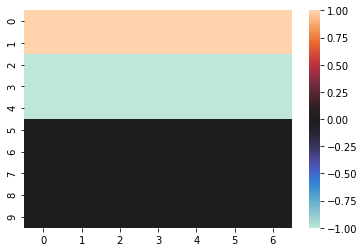

In [7]:
# multiple response linear regression with row sparsity
# not this coefficent matrix is also low rank
X, y, coef, intercept = sample_sparse_lin_reg(n_samples=100, n_features=10, n_nonzero=5,
                                              n_responses=7, random_state=1)

sns.heatmap(coef, center=0)

In [8]:
Est, EstCV = get_pen_glm(loss_func='lin_reg_mr', penalty='lasso')
Est_adpt, EstCV_adpt = get_pen_glm(loss_func='lin_reg_mr', penalty='adpt_lasso')
Est_fcp, EstCV_fcp = get_pen_glm(loss_func='lin_reg_mr', penalty='fcp_lla')


# Entrywise Lasso
est = EstCV().fit(X, y)
print('Entrywise lasso L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))


# Multi-task lasso
est = EstCV(estimator=Est(multi_task=True)).fit(X, y)
print('\nMulti-task Lasso L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))

# Multi-task lasso with folded concave penalty
est = EstCV_adpt(Est_adpt(multi_task=True)).fit(X, y)
print('Adaptive multi-task lasso L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))

# Multi-task lasso with folded concave penalty
est = EstCV_fcp(Est_fcp(multi_task=True)).fit(X, y)
print('FCP multi-task with LLA L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))


# Nuclear norm
est = EstCV(estimator=Est(nuc=True)).fit(X, y)
print('\nNuclear norm L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))

# Adaptive nuclear norm
est = EstCV_adpt(Est_adpt(nuc=True)).fit(X, y)
print('Adaptive nuclear norm L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))

# Nuclear norm with folded concave penalty
est = EstCV_fcp(Est_fcp(nuc=True)).fit(X, y)
print('FCP nuclear nrom with LLA L2 to truth', np.linalg.norm(est.best_estimator_.coef_ - coef))

Entrywise lasso L2 to truth 0.9119237212284282

Multi-task Lasso L2 to truth 0.8684943342448098
Adaptive multi-task lasso L2 to truth 0.7141545319969675
FCP multi-task with LLA L2 to truth 0.7502835459738096

Nuclear norm L2 to truth 0.7099944507829721
Adaptive nuclear norm L2 to truth 0.47362674050743064
FCP nuclear nrom with LLA L2 to truth 0.507907042256749
